# Explore Normalized Biotype exploration

compare the transcript biotypes between the kras.ipsc data sets for  day 5 and 7. Counts where normalized using DESeq. see  R/notebooks/kras.ipsc.DESeq.normalize.Rmd

## load  transcipt level count and bio type data
data files created by extraCellularRNA/R/notebooks/kras.ipsc.DESeq.normalize.Rmd


## TODO


In [1]:
from   bme263DataVis.utilities import MatPlotLibUtilities
from   bme263DataVis.plotCumulativeProbablty import PlotCumulativeProbablity
from   bme263DataVis.plotProbMassFunc import PlotProbMass

# https://songhuiming.github.io/pages/2017/04/02/jupyter-and-pandas-display/
# display(HTML(' <span style="color:red">the title is: <h1>Hello, world!</h1> </span>  '))
# display(HTML(df.to_html()))
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib as pl

mplu = MatPlotLibUtilities()
mplu.loadStyle()

# macbookpro = "../data/R/output"
# courtyard = "../R/output"
# biodataRootDir = courtyard
biodataRootDir = "../data/R/output"

day5 = 5
day7 = 7
day5And7 = day5 + day7

# select data set
day = day5And7

print("using day:{} data sets".format(day))

np.random.seed(42)

using day:12 data sets


## load data sets

In [2]:
if day == day5 :
    imgOutDir = pl.Path("../data/exploreNormalizedBiotypeTranscriptCounts.out/kras.ipsc").joinpath("day5/img")    
    dataFile = "kras.ipsc.data.day.5.bulk_exo.normalized.deseq.biotype.counts.csv"
    title = "kras.ipsc day 5 DESeq normalized"
    titleWithSpread = "kras.ipsc day 5 DESeq normalized add spread"
    hasExo = True
    dayStr = str(5)

elif day == day7:
    imgOutDir = pl.Path("../data/exploreNormalizedBiotypeTranscriptCounts.out/kras.ipsc").joinpath("day7/img")        
    dataFile = "kras.ipsc.data.day.7.bulk.normalized.deseq.biotype.counts.csv"
    title = "kras.ipsc day 7 DESeq normalized"
    titleWithSpread = "kras.ipsc day 7 DESeq normalized add spread"
    hasExo = False
    dayStr = str(7)
    
elif day == day5And7:
    imgOutDir = pl.Path("../data/exploreNormalizedBiotypeTranscriptCounts.out/kras.ipsc").joinpath("day5And7/img") 
    dataFile5 = "kras.ipsc.data.day.5.bulk_exo.normalized.deseq.biotype.counts.csv"
    dataFile7 = "kras.ipsc.data.day.7.bulk.normalized.deseq.biotype.counts.csv"
    title = "kras.ipsc day 5 &7 DESeq normalized"
    titleWithSpread = "kras.ipsc day 5 & 7 DESeq normalized add spread"
    hasExo = False # day 7 does not have exo   
    dayStr = "5&7"

else:
    print("ERROR set 'day' to select data set")

imgOutDir.mkdir(parents=True, exist_ok=True)

In [3]:
def renameCol(df):
    colNamesList = df.columns.to_list()
    colNamesList[0] = "biotype"
    df.columns = colNamesList  
    df.set_index('biotype', inplace=True)

if day == day5And7:
    filePath5 = pl.Path(biodataRootDir, dataFile5)
    print(filePath5)
    df5 = pd.read_csv(filePath5)
    renameCol(df5)
    
    # remove exo cols. day 7 is bulk only
    bulkColNames = [c for c in df5.columns if c.startswith('bulk')]
    df5 = df5.loc[:, bulkColNames]
    
    filePath7 = pl.Path(biodataRootDir, dataFile7)
    print(filePath7)
    
    df7 = pd.read_csv(filePath7)
    renameCol(df7)
    
else:
    filePath = pl.Path(biodataRootDir, dataFile)
    print(filePath)
    df = pd.read_csv(filePath)
    renameCol(df)

../data/R/output/kras.ipsc.data.day.5.bulk_exo.normalized.deseq.biotype.counts.csv
../data/R/output/kras.ipsc.data.day.7.bulk.normalized.deseq.biotype.counts.csv


In [4]:
def getNumberOfReplicants(df):
    '''
    assumes data sets are defined by sampleType and treatment and that
    all data sets have have the same number of replicants.
    
    i.e. they are balanced
    '''
    colNames = df.columns[1:] # skip the biotype col
    repliciants = list()
    for colName in colNames:
        repliciants.append( int(colName.split('_')[-1]) )
        
    ret = max( repliciants )
    return ret

In [5]:
def combineReplicants( df, numReplicants ):
    '''
    arguments:
        numReplicants: an integer assume all 'conditions' have same number for
        replicants
        
    returns:
        dictionary of data frames. each c
    '''
    
    # create a dictionary of combined replicants
    # we will use this to create the returned data frame
    retDataDict = dict()
    
    # find prefixes. e.g. 'exo_kras', 'bulk_kras', ...
    prefixList = []
    for tokens in [colName.split("_") for colName in df.columns] :
        prefixList.append( tokens[0] + "_" + tokens[1])

    # get unique prefixes
    prefixList = set( prefixList )


    for prefix in prefixList:
        selectColNames = [prefix + "_" + str(i + 1) for i in range(numReplicants)]
        # print(selectColNames)
        # example col names exo_kras_1  exo_kras_2  exo_kras_3
        replicantDF = df.loc[:,selectColNames]
        rowAxis = 1
        combineSeries = replicantDF.sum(axis=rowAxis)
        retDataDict[prefix] = combineSeries
        
    retDF = pd.DataFrame(retDataDict)
        
    return retDF

In [6]:
def prepareDF(df, day):
    numReplicants = getNumberOfReplicants(df)
    conditionDF = combineReplicants(df, numReplicants ) 
    colNames = [ c + "_" + str(day) for c in conditionDF.columns]
    conditionDF.columns = colNames
    
    return(conditionDF)

In [7]:
if day == day5And7:
    conditionDF5 = prepareDF(df5, day=day5)
    conditionDF7 = prepareDF(df7, day=day7)
    colsAxis = 1 
    # join: outer is union inner is intersection
    conditionDF = pd.concat([conditionDF5, conditionDF7], axis=colsAxis, join='outer', sort=False) 
    conditionDF.fillna(0.0, inplace=True) # replace missing biotype values, ie. NaN with zero
#     print(conditionDF.columns)
#     print(conditionDF.shape)
    
else:
    numReplicants = getNumberOfReplicants(df)
    conditionDF = combineReplicants(df, numReplicants )   

In [8]:
conditionDF    

,bulk_ctrl_5,bulk_kras_5,bulk_ctrl_7,bulk_kras_7
IG_V_gene,2.524914e+00,2.188076e+00,0.000000e+00,0.000000e+00
IG_V_pseudogene,5.541918e+00,4.579391e+00,0.000000e+00,0.000000e+00
lncRNA,1.604063e+06,1.810491e+06,2.578074e+06,2.643954e+06
miRNA,1.943653e+02,2.498626e+02,1.898601e+02,1.707723e+02
misc_RNA,7.699910e+03,6.233013e+03,1.238337e+03,1.180557e+03
Mt_rRNA,1.865429e+05,1.932394e+05,6.896370e+05,6.975322e+05
non_stop_decay,2.374030e+03,2.842930e+03,6.467617e+03,7.574394e+03
nonsense_mediated_decay,1.007424e+06,1.115403e+06,2.218353e+06,2.233948e+06
polymorphic_pseudogene,3.924077e+01,5.221178e+01,3.594322e+02,2.643209e+02
processed_pseudogene,8.111194e+04,9.088459e+04,1.451415e+05,1.466586e+05


## Convert to probablities and explore cumlative distribution function
counts can not be compared directly. We expect bulk samples to have more transcript counts than exo samples

In [9]:
def convertCountsToProb(countDF):
    '''
    adds psudo count
    
    Kullback–Leibler divergence will be inf if any of the predicted probablities are zero
    '''
    tmpDF = countDF + 1
    colSums = tmpDF.sum()
    ret = tmpDF / colSums
    return ret

In [10]:
# aedwip we set the index to biotype, no need to skip. is this day 12 only?

# # can not calc probablity of biotype column. biotypes are strings not counts
# bioTypeProbDF = convertCountsToProb(conditionDF.iloc[:, 1:])
bioTypeProbDF = convertCountsToProb(conditionDF)
bioTypeProbDF.tail()

# sanity check. each column must sum to 1.0
assert sum( bioTypeProbDF.sum() ) == len(bioTypeProbDF.columns) 

In [11]:
bioTypeProbDF.index

Index(['IG_V_gene', 'IG_V_pseudogene', 'lncRNA', 'miRNA', 'misc_RNA',
       'Mt_rRNA', 'non_stop_decay', 'nonsense_mediated_decay',
       'polymorphic_pseudogene', 'processed_pseudogene', 'protein_coding',
       'pseudogene', 'retained_intron', 'ribozyme', 'rRNA', 'rRNA_pseudogene',
       'scaRNA', 'scRNA', 'snoRNA', 'snRNA', 'TEC', 'TR_C_gene', 'TR_V_gene',
       'TR_V_pseudogene', 'transcribed_processed_pseudogene',
       'transcribed_unitary_pseudogene', 'transcribed_unprocessed_pseudogene',
       'unitary_pseudogene', 'unprocessed_pseudogene', 'Mt_tRNA'],
      dtype='object')

In [12]:
bioTypeProbDF

,bulk_ctrl_5,bulk_kras_5,bulk_ctrl_7,bulk_kras_7
IG_V_gene,8.123859e-08,6.720593e-08,1.119502e-08,1.081274e-08
IG_V_pseudogene,1.507714e-07,1.176158e-07,1.119502e-08,1.081274e-08
lncRNA,3.696881e-02,3.816590e-02,2.886159e-02,2.858840e-02
miRNA,4.502578e-06,5.288285e-06,2.136682e-06,1.857329e-06
misc_RNA,1.774826e-04,1.314155e-04,1.387439e-05,1.277587e-05
Mt_rRNA,4.299272e-03,4.073584e-03,7.720508e-03,7.542245e-03
non_stop_decay,5.473723e-05,5.995119e-05,7.241626e-05,8.191077e-05
nonsense_mediated_decay,2.321809e-02,2.351317e-02,2.483451e-02,2.415511e-02
polymorphic_pseudogene,9.274278e-07,1.121726e-06,4.035044e-06,2.868846e-06
processed_pseudogene,1.869407e-03,1.915905e-03,1.624873e-03,1.585792e-03


## find missing biotypes
There are some missing biotypes however they are probably not signifigant becuase their probaliby masss is almost zero

In [13]:
if day == day5And7 :
    biotype5Set = set(df5.index)    
    biotype7Set = set(df7.index)
    
    in5missingIn7 = biotype5Set.difference(biotype7Set)
    in7MissingIn5 = biotype7Set.difference(biotype5Set)
    
    print("biotypes in day 5 bulk that are not in day 7\n{}".format(in5missingIn7))    
    print("\nbiotypes in day 7 bulk that are not in day 5\n{}".format(in7MissingIn5))

biotypes in day 5 bulk that are not in day 7
{'TR_V_pseudogene', 'IG_V_gene', 'IG_V_pseudogene', 'rRNA_pseudogene'}

biotypes in day 7 bulk that are not in day 5
{'Mt_tRNA'}


In [14]:
selectMissingBiotypes = list(in5missingIn7) + list(in7MissingIn5)
print(selectMissingBiotypes)
axisCols = 1
bioTypeProbDF.loc[selectMissingBiotypes,:].sum(axis=axisCols)

['TR_V_pseudogene', 'IG_V_gene', 'IG_V_pseudogene', 'rRNA_pseudogene', 'Mt_tRNA']


TR_V_pseudogene    7.113177e-07
IG_V_gene          1.704523e-07
IG_V_pseudogene    2.903949e-07
rRNA_pseudogene    1.427475e-06
Mt_tRNA            5.827896e-07
dtype: float64

## Plot

../data/exploreNormalizedBiotypeTranscriptCounts.out/kras.ipsc/day5And7/img/day5&7AllConditions.png


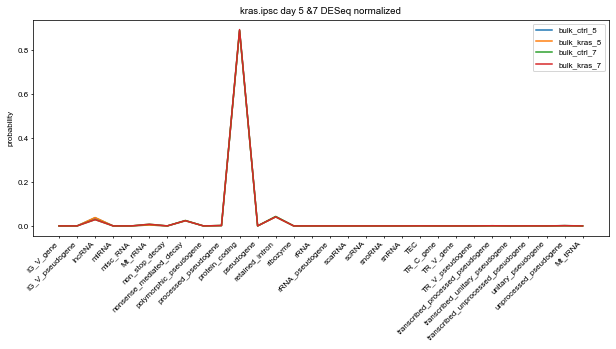

In [15]:
# create panel
figureWidthInInches = 8
figureHeightInInches = 3
fig = plt.figure(figsize=(figureWidthInInches,figureHeightInInches))
panel = mplu.createPanelSameSizeAsFig(fig)

legendLabels = None 
PlotProbMass(panel, bioTypeProbDF, legendLabels, title)
outfile = imgOutDir.joinpath("day" + dayStr +"AllConditions.png")
print(outfile)
# if you do not set bbox_inches saved img will be clipped
fig.savefig(outfile, bbox_inches='tight') #BME163 style sheet should set dpi=600

In [16]:
if day != day5And7:
    # create panel
    figureWidthInInches = 8
    figureHeightInInches = 3
    fig = plt.figure(figsize=(figureWidthInInches,figureHeightInInches))
    panel = mplu.createPanelSameSizeAsFig(fig)

    legendLabels = None #bioTypeProbDF.columns.to_numpy()
    bioTypeProbDF["bulk_ctrl+"] = bioTypeProbDF["bulk_ctrl"] + 0.05
    PlotProbMass(panel, bioTypeProbDF.loc[:,["bulk_ctrl+", "bulk_kras"]], legendLabels, titleWithSpread)
    outfile = imgOutDir.joinpath("bulk_ctrl+_bulk_kras.png")
    print(outfile)
    # if you do not set bbox_inches saved img will be clipped
    fig.savefig(outfile, bbox_inches='tight') #BME163 style sheet should set dpi=600

In [17]:
if hasExo :
    # create panel
    figureWidthInInches = 8
    figureHeightInInches = 3
    fig = plt.figure(figsize=(figureWidthInInches,figureHeightInInches))
    panel = mplu.createPanelSameSizeAsFig(fig)

    legendLabels = None #bioTypeProbDF.columns.to_numpy()
    print(legendLabels)
    #bioTypeProbDF["exo_ctrl+"] = bioTypeProbDF["exo_ctrl"] + 0.05
    PlotProbMass(panel, bioTypeProbDF.loc[:,["exo_ctrl", "exo_kras"]], legendLabels, titleWithSpread)
    outfile = imgOutDir.joinpath("exo_ctrl_kras.png")
    print(outfile)    
    # if you do not set bbox_inches saved img will be clipped
    fig.savefig(outfile, bbox_inches='tight') #BME163 style sheet should set dpi=600

In [18]:
if hasExo :
    # create panel
    figureWidthInInches = 8
    figureHeightInInches = 3
    fig = plt.figure(figsize=(figureWidthInInches,figureHeightInInches))
    panel = mplu.createPanelSameSizeAsFig(fig)

    legendLabels = None #bioTypeProbDF.columns.to_numpy()
    print(legendLabels)
    #bioTypeProbDF["exo_ctrl+"] = bioTypeProbDF["exo_ctrl"] + 0.05
    PlotProbMass(panel, bioTypeProbDF.loc[:,["bulk_ctrl", "exo_ctrl"]], legendLabels, titleWithSpread)
    outfile = imgOutDir.joinpath("bulk_exo_ctrl.png")
    print(outfile)
    # if you do not set bbox_inches saved img will be clipped
    fig.savefig(outfile, bbox_inches='tight') #BME163 style sheet should set dpi=600

In [19]:
if hasExo :
    # create panel
    figureWidthInInches = 8
    figureHeightInInches = 3
    fig = plt.figure(figsize=(figureWidthInInches,figureHeightInInches))
    panel = mplu.createPanelSameSizeAsFig(fig)

    legendLabels = None #bioTypeProbDF.columns.to_numpy()
    print(legendLabels)
    #bioTypeProbDF["exo_ctrl+"] = bioTypeProbDF["exo_ctrl"] + 0.05
    PlotProbMass(panel, bioTypeProbDF.loc[:,["bulk_kras", "exo_kras"]], legendLabels, titleWithSpread)

    outfile = imgOutDir.joinpath("bulk_exo_kras.png")
    print(outfile)
    # if you do not set bbox_inches saved img will be clipped
    fig.savefig(outfile, bbox_inches='tight') #BME163 style sheet should set dpi=600